##### This Notebook is used to generate, clean, and manipulate data from a NYC Green Taxi data source
##### from bronze layer
####  
##### And then load the Incremental output into a Lakehouse Silver Layer..
##### 
##### 
##### 
##### The particular dataset being used in this example is the New York City Green Taxi dataset.

In [1]:

# Loading the necessary libraries
from pyspark.sql import SparkSession
from datetime import datetime
from dateutil import parser,relativedelta
import pyspark.sql.functions as f
from pyspark.sql.functions import year, month, dayofmonth, dayofweek, hour, to_date, col, quarter, explode, sequence, expr,current_timestamp,lit
from pyspark.sql.types import StructType, StructField, IntegerType, TimestampType, DoubleType, StringType, FloatType, ArrayType, LongType
from delta.tables import DeltaTable
from notebookutils import mssparkutils


StatementMeta(, 366f67f5-8c39-48f2-b590-8e2438d437f0, 5, Finished, Available)

##### Generate a Date Dimension Table

In [2]:
# create a fucntion for  date dimension table
def generate_date_dimension(start_date: str, end_date: str):
 
     # DataFrame with a range of dates
    date_df = spark.createDataFrame([(start_date, end_date)], ["start", "end"])

    # gnerating  a new row for each date between the start and end dates
    date_df = date_df.select(explode(sequence(to_date("start"), to_date("end"), expr("interval 1 day"))).alias("date"))
    
    
    date_df = date_df.selectExpr(
        "date",
        "year(date) as year",
        "quarter(date) as quarter",
        "month(date) as month",
        "day(date) as day",
        "dayofweek(date) as day_of_week",
        "to_date(date) as date_key"
    )

    return date_df

StatementMeta(, 7ae71e97-6be0-4c2f-9349-996ad220ca86, 6, Finished, Available)

##### Loading Date Dimension in Silver Layer

In [3]:
date_dimension_df = generate_date_dimension("2014-05-01", "2018-06-06")
date_dimension_df.write.format('delta').option("overwriteSchema", "true").saveAsTable("Dates", mode="overwrite")

StatementMeta(, 7ae71e97-6be0-4c2f-9349-996ad220ca86, 7, Finished, Available)

In [2]:
# Creating path for a checkpointfile where the metadata will live while writing the stream
basepath ="Tables/nycgreentaxi_temp/"
checkpoint_dir = 'Tables/nycgreentaxi_temp/_checkpoint'


StatementMeta(, 366f67f5-8c39-48f2-b590-8e2438d437f0, 6, Finished, Available)

##### Load data from bronze depending on the `delta_load` flag.
##### If `delta_load` is 0, it checks and removes the checkpoint directory if exists, before loading the data.
##### Data is loaded from a delta format source into `Readdf` as Stream 

In [3]:
delta_load=1

StatementMeta(, 366f67f5-8c39-48f2-b590-8e2438d437f0, 7, Finished, Available)

In [4]:
if delta_load == 0:
    # Check if the checkpoint directory exists before removing it
    if mssparkutils.fs.exists(checkpoint_dir):
        mssparkutils.fs.rm(checkpoint_dir, True)
    Readdf = (spark.readStream.format("delta").option("ignoreChanges",True).load('abfss://Demo@onelake.dfs.fabric.microsoft.com/bronze_nyc_tlc_green.Lakehouse/Tables/nycgreentaxi'))
else:
    Readdf = (spark.readStream.format("delta").option("ignoreChanges",True).load('abfss://Demo@onelake.dfs.fabric.microsoft.com/bronze_nyc_tlc_green.Lakehouse/Tables/nycgreentaxi'))
 


StatementMeta(, 366f67f5-8c39-48f2-b590-8e2438d437f0, 8, Finished, Available)

In [5]:
Readdf =Readdf.withColumn("Silver_Loadedtimestamp", current_timestamp())

StatementMeta(, 366f67f5-8c39-48f2-b590-8e2438d437f0, 9, Finished, Available)

 ##### Define the function `writeTonyncgreentaxi_inc` which writes a DataFrame to the table "nycgreentaxi_temp" in delta format in Overwrite mode

In [6]:
def writeTonyncgreentaxi_inc (df,epoch_id):

 df.write.format("delta")\
              .mode("overwrite")\
              .option("overwritechema", "true")\
              .saveAsTable("nycgreentaxi_temp")

StatementMeta(, 366f67f5-8c39-48f2-b590-8e2438d437f0, 10, Finished, Available)

##### Write `Readdf` to the table "nycgreentaxi_temp" in delta format in a streaming manner as batch baseda pproach i.e trigger Once is true
##### Checkpointing is enabled and the checkpoint location is defined by `checkpoint_dir`.

In [7]:
# Define the streaming write operation with format, foreachBatch and checkpoint location
Inc_Query = Readdf.writeStream.format("delta")\
    .foreachBatch(writeTonyncgreentaxi_inc)\
    .option("checkpointLocation", checkpoint_dir)\
    .trigger(once=True)\
    .start()

# Await for the termination of the stream
Inc_Query.awaitTermination()


StatementMeta(, 366f67f5-8c39-48f2-b590-8e2438d437f0, 11, Finished, Available)

##### Analyse the Temp table 

In [10]:
df = spark.sql("SELECT max(date_key),min(date_key) FROM silver_nyc_tlc_green_enrich.nycgreentaxi_temp LIMIT 1000")
display(df)

StatementMeta(, 7ae71e97-6be0-4c2f-9349-996ad220ca86, 14, Finished, Available)

SynapseWidget(Synapse.DataFrame, bdfb0579-372c-41dc-a916-c2c9a74741c1)

In [9]:
df = spark.sql("SELECT max(date_key),min(date_key) FROM silver_nyc_tlc_green_enrich.nycgreentaxi_temp LIMIT 1000")
display(df)

StatementMeta(, 366f67f5-8c39-48f2-b590-8e2438d437f0, 13, Finished, Available)

SynapseWidget(Synapse.DataFrame, 508c7e9e-7a31-40e9-bc22-d1c231813d4e)

##### Cleanup: Disable retention duration check and remove old data in the "nycgreentaxi_temp" table.

In [11]:
spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled", "false")
spark.sql("VACUUM silver_nyc_tlc_green_enrich.nycgreentaxi_temp RETAIN 0 HOURS").show()


StatementMeta(, 7ae71e97-6be0-4c2f-9349-996ad220ca86, 15, Finished, Available)

+--------------------+
|                path|
+--------------------+
|abfss://214fe4c8-...|
+--------------------+



##### SQL query to create a temporary view "nycgreentaxi_removeduplicates" which removes duplicates from the "nycgreentaxi_temp" table

In [22]:
%%sql
CREATE OR REPLACE TEMP VIEW nycgreentaxi_removeduplicates AS

SELECT ROW_NUMBER() OVER(PARTITION BY lpepPickupDatetime, lpepDropoffDatetime, vendorID, puLocationId,totalAmount,dropoffLatitude,dropoffLongitude,pickupLatitude
            ,pickupLongitude,extra,fareAmount ORDER BY bronze_loaded_timestamp DESC )as row_id
            ,Silver_Loadedtimestamp
            ,date_key
            ,day_of_month
            ,day_of_week
            ,doLocationId
            ,dropoffLatitude
            ,dropoffLongitude
            ,ehailFee
            ,extra
            ,fareAmount
            ,hour
            ,improvementSurcharge
            ,lpepDropoffDatetime
            ,lpepPickupDatetime
            ,month
            ,mtaTax
            ,passengerCount
            ,paymentType
            ,pickupLatitude
            ,pickupLongitude
            ,puLocationId
            ,rateCodeID
            ,storeAndFwdFlag
            ,tipAmount
            ,tollsAmount
            ,totalAmount
            ,tripDistance
            ,tripType
            ,vendorID
            ,year
FROM silver_nyc_tlc_green_enrich.nycgreentaxi_temp


StatementMeta(, 7ae71e97-6be0-4c2f-9349-996ad220ca86, 31, Finished, Available)

<Spark SQL result set with 0 rows and 0 fields>

##### Creating temporary view "nycgreentaxi_enrich" which enriches the "nycgreentaxi_removeduplicates" view with data Already present on ADLS fetched as Shortcut named "publicholidays_reference".

In [23]:
%%sql
CREATE OR REPLACE TEMP VIEW nycgreentaxi_enrich AS

select nyc_dup.*,pub.holidayName as holiday_name ,pub.isPaidTimeOff from nycgreentaxi_removeduplicates as nyc_dup
LEFT JOIN silver_nyc_tlc_green_enrich.publicholidays_reference as  pub
ON pub.date_key =nyc_dup.date_key and Countrycode='US'
where nyc_dup.row_id =1


StatementMeta(, 7ae71e97-6be0-4c2f-9349-996ad220ca86, 32, Finished, Available)

<Spark SQL result set with 0 rows and 0 fields>

##### Create a Visual Charts on order to analyse the Taxi data on regular days vs holidays 

StatementMeta(, 7ae71e97-6be0-4c2f-9349-996ad220ca86, 33, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/utils.py:64: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.



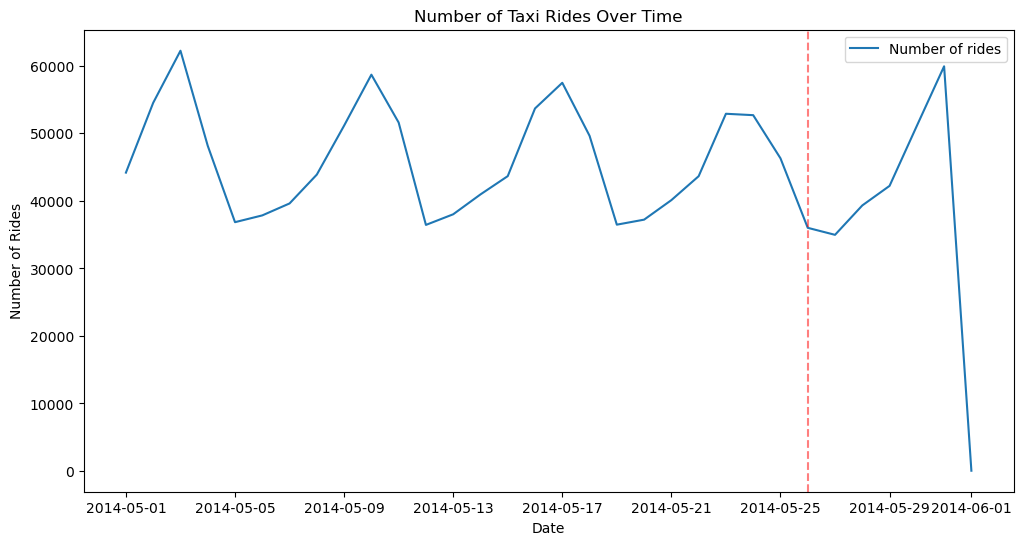

In [24]:
import matplotlib.pyplot as plt

# Group by date and count the number of rides
rides_per_day = spark.sql("""
SELECT 
    date_key, 
    count(*) as num_rides, 
    max(holiday_name) as holiday_name
FROM 
    nycgreentaxi_enrich
GROUP BY 
    date_key
ORDER BY 
    date_key
""").toPandas()

# Plot the time series
plt.figure(figsize=(12,6))
plt.plot(rides_per_day['date_key'], rides_per_day['num_rides'], label='Number of rides')

# Highlight holidays
for i in rides_per_day[rides_per_day['holiday_name'].notna()].index:
    plt.axvline(x=rides_per_day['date_key'][i], color='r', linestyle='--', alpha=0.5)

plt.title('Number of Taxi Rides Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.legend()
plt.show()


StatementMeta(, 7ae71e97-6be0-4c2f-9349-996ad220ca86, 34, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/utils.py:64: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.



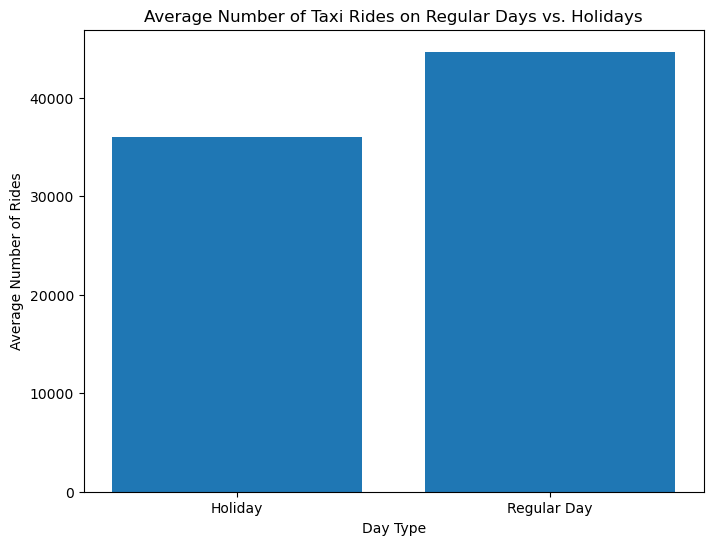

In [25]:
# Compute average number of rides on regular days and holidays
avg_rides = spark.sql("""
SELECT 
    IF(holiday_name IS NULL, 'Regular Day', 'Holiday') as day_type, 
    AVG(num_rides) as avg_rides
FROM (
    SELECT 
        date_key, 
        count(*) as num_rides, 
        max(holiday_name) as holiday_name
    FROM 
        nycgreentaxi_enrich
    GROUP BY 
        date_key
) subquery
GROUP BY 
    day_type
""").toPandas()

# Plot the bar chart
plt.figure(figsize=(8,6))
plt.bar(avg_rides['day_type'], avg_rides['avg_rides'])
plt.title('Average Number of Taxi Rides on Regular Days vs. Holidays')
plt.xlabel('Day Type')
plt.ylabel('Average Number of Rides')
plt.show()



In [26]:
JobName="Nycgreentaxi_Bronze_to_Silver"
FinalView = "nycgreentaxi_enrich" # Final Enriched View
lakehouse = "silver_nyc_tlc_green_enrich" # target lakehouse
table = "nycgreentaxi_enriched" # Target Table
path_to_delta_table = "Tables"+ "/" + table
JobName = "Nycgreentaxi_Bronze_to_Silver" # Define your JobName here
nycgreentaxi_df = spark.sql(f"SELECT * FROM {FinalView}")
nycgreentaxi_df = nycgreentaxi_df.withColumn("Fabricnloadingjobname", lit(JobName))


StatementMeta(, 7ae71e97-6be0-4c2f-9349-996ad220ca86, 35, Finished, Available)

##### Quality Checks:- Here we are validating that certain columns in the DataFrame nycgreentaxi_df are unique and not null. The validate function will check all the expectations we've set up and return the results.

In [27]:
import great_expectations as ge
import great_expectations.dataset.sparkdf_dataset as sd

StatementMeta(, 7ae71e97-6be0-4c2f-9349-996ad220ca86, 36, Finished, Available)

In [28]:
# Convert Spark DataFrame to Great Expectations Dataset
ge_df = ge.dataset.SparkDFDataset(nycgreentaxi_df)

# Define Expectations
ge_df.expect_column_values_to_be_unique('lpepPickupDatetime')
ge_df.expect_column_values_to_be_unique('lpepDropoffDatetime')
ge_df.expect_column_values_to_be_unique('vendorID')
ge_df.expect_column_values_to_be_unique('puLocationId')
ge_df.expect_column_values_to_not_be_null('totalAmount')
ge_df.expect_column_values_to_not_be_null('dropoffLatitude')
ge_df.expect_column_values_to_not_be_null('dropoffLongitude')
ge_df.expect_column_values_to_not_be_null('pickupLatitude')
ge_df.expect_column_values_to_not_be_null('pickupLongitude')
ge_df.expect_column_values_to_not_be_null('extra')
ge_df.expect_column_values_to_not_be_null('fareAmount')

# Validate Expectations
results = ge_df.validate()

print(results)


StatementMeta(, 7ae71e97-6be0-4c2f-9349-996ad220ca86, 37, Finished, Available)

{
  "evaluation_parameters": {},
  "meta": {
    "great_expectations_version": "0.17.0",
    "expectation_suite_name": "default",
    "run_id": {
      "run_time": "2023-06-18T18:23:32.128601+00:00",
      "run_name": null
    },
    "batch_kwargs": {
      "ge_batch_id": "28d883be-0e05-11ee-9a25-6045bddce112"
    },
    "batch_markers": {},
    "batch_parameters": {},
    "validation_time": "20230618T182332.128527Z",
    "expectation_suite_meta": {
      "great_expectations_version": "0.17.0"
    }
  },
  "results": [
    {
      "result": {
        "element_count": 1421543,
        "missing_count": 0,
        "missing_percent": 0.0,
        "unexpected_count": 668599,
        "unexpected_percent": 47.03332927670848,
        "unexpected_percent_total": 47.03332927670848,
        "unexpected_percent_nonmissing": 47.03332927670848,
        "partial_unexpected_list": [
          "2014-05-01T00:00:52",
          "2014-05-01T00:00:52",
          "2014-05-01T00:00:52",
          "2014-05-01

 ##### Merging the Incremental captured Enriched view into a Target Silver Table 

In [29]:
# Check if Delta table exists
if mssparkutils.fs.exists(path_to_delta_table):
    deltaTable = DeltaTable.forPath(spark, path_to_delta_table)
else:
    # Create Delta table
    nycgreentaxi_df.write.format("delta").save(path_to_delta_table)
    deltaTable = DeltaTable.forPath(spark, path_to_delta_table)

# Define merge condition
merge_condition = (
    "sourceview.lpepPickupDatetime = target.lpepPickupDatetime and "
    "sourceview.lpepDropoffDatetime = target.lpepDropoffDatetime and "
    "sourceview.vendorID = target.vendorID and "
    "sourceview.puLocationId = target.puLocationId and "
    "sourceview.totalAmount = target.totalAmount and "
    "sourceview.dropoffLatitude = target.dropoffLatitude and "
    "sourceview.dropoffLongitude = target.dropoffLongitude and "
    "sourceview.pickupLatitude = target.pickupLatitude and "
    "sourceview.pickupLongitude = target.pickupLongitude and "
    "sourceview.extra = target.extra and "
    "sourceview.fareAmount = target.fareAmount"
)

# Execute merge
(
 deltaTable.alias("target").merge(
    nycgreentaxi_df.alias("sourceview"),
    merge_condition
 ).whenMatchedUpdateAll().whenNotMatchedInsertAll().execute()
)

StatementMeta(, 7ae71e97-6be0-4c2f-9349-996ad220ca86, 38, Finished, Available)

#### Conclusion
#### The code demonstrates a robust Incremental pipeline for processing data at scale using Checkpoint Method from Structures Streaming . By adopting Streaming  pipeline as batch data professionals can effectively manage and analyze  data, deriving valuable insights and focus on decision-making processes without worrying of metadata management